# Getting started with PPO and ProcGen

Here's a bit of code that should help you get started on your projects.

The cell below installs `procgen` and downloads a small `utils.py` script that contains some utility functions. You may want to inspect the file for more details.

In [1]:
!pip install procgen
!wget https://raw.githubusercontent.com/nicklashansen/ppo-procgen-utils/main/utils.py
!wget https://raw.githubusercontent.com/MishaLaskin/rad/1246bfd6e716669126e12c1f02f393801e1692c1/TransformLayer.py

     |████████████████████████████████| 39.9MB 81kB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 204kB 54.7MB/s 
     |████████████████████████████████| 665kB 56.4MB/s 
     |████████████████████████████████| 22.2MB 1.4MB/s 
     |████████████████████████████████| 3.3MB 51.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
--2020-12-09 21:57:18--  https://raw.githubusercontent.com/nicklashansen/ppo-procgen-utils/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14807 (14K) [text/plain]
Saving to: ‘utils.py’

Data aug code from
https://github.com/MishaLaskin/rad/blob/1246bfd6e716669126e12c1f02f393801e1692c1/data_augs.py#L296


In [2]:
'''
dataaugs:
https://github.com/MishaLaskin/rad/blob/1246bfd6e716669126e12c1f02f393801e1692c1/data_augs.py#L296
'''
'''
paper:
https://arxiv.org/pdf/2004.14990.pdf
'''
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from TransformLayer import ColorJitterLayer


def random_crop(imgs, out=84):
    """
        args:
        imgs: np.array shape (B,C,H,W)
        out: output size (e.g. 84)
        returns np.array
    """
    n, c, h, w = imgs.shape
    
    crop_max = h - out + 1
    w1 = np.random.randint(0, crop_max, n)
    h1 = np.random.randint(0, crop_max, n)
    cropped = np.empty((c, out, out), dtype=imgs.dtype)
    cropped = imgs[:, h1+out, w1+out]
    cropped = np.empty((n, c, out, out), dtype=imgs.dtype)
    for i, (img, w11, h11) in enumerate(zip(imgs, w1, h1)):
        
        cropped[i] = img[:, h11:h11 + out, w11:w11 + out]
    return cropped


def grayscale(imgs):
    # imgs: b x c x h x w
    device = imgs.device
    b, c, h, w = imgs.shape
    frames = c // 3
    
    imgs = imgs.view([b,frames,3,h,w])
    imgs = imgs[:, :, 0, ...] * 0.2989 + imgs[:, :, 1, ...] * 0.587 + imgs[:, :, 2, ...] * 0.114 
    
    imgs = imgs.type(torch.uint8).float()
    # assert len(imgs.shape) == 3, imgs.shape
    imgs = imgs[:, :, None, :, :]
    imgs = imgs * torch.ones([1, 1, 3, 1, 1], dtype=imgs.dtype).float().to(device) # broadcast tiling
    return imgs

def random_grayscale(images,p=.3):
    """
        args:
        imgs: torch.tensor shape (B,C,H,W)
        device: cpu or cuda
        returns torch.tensor
    """
    device = images.device
    in_type = images.type()
    images = images * 255.
    images = images.type(torch.uint8)
    # images: [B, C, H, W]
    bs, channels, h, w = images.shape
    images = images.to(device)
    gray_images = grayscale(images)
    rnd = np.random.uniform(0., 1., size=(images.shape[0],))
    mask = rnd <= p
    mask = torch.from_numpy(mask)
    frames = images.shape[1] // 3
    images = images.view(*gray_images.shape)
    mask = mask[:, None] * torch.ones([1, frames]).type(mask.dtype)
    mask = mask.type(images.dtype).to(device)
    mask = mask[:, :, None, None, None]
    out = mask * gray_images + (1 - mask) * images
    out = out.view([bs, -1, h, w]).type(in_type) / 255.
    return out

# random cutout
# TODO: should mask this 

def random_cutout(imgs, min_cut=10,max_cut=30):
    """
        args:
        imgs: np.array shape (B,C,H,W)
        min / max cut: int, min / max size of cutout 
        returns np.array
    """

    n, c, h, w = imgs.shape
    w1 = np.random.randint(min_cut, max_cut, n)
    h1 = np.random.randint(min_cut, max_cut, n)
    
    cutouts = np.empty((n, c, h, w), dtype=imgs.dtype)
    for i, (img, w11, h11) in enumerate(zip(imgs, w1, h1)):
        cut_img = img.copy()
        cut_img[:, h11:h11 + h11, w11:w11 + w11] = 0
        #print(img[:, h11:h11 + h11, w11:w11 + w11].shape)
        cutouts[i] = cut_img
    return cutouts

def random_cutout_color(imgs, min_cut=100,max_cut=250):
    """
        args:
        imgs: shape (B,C,H,W)
        out: output size (e.g. 84)
    """
    n, c, h, w = imgs.shape
    w1 = np.random.randint(min_cut, max_cut, n)
    h1 = np.random.randint(min_cut, max_cut, n)
    
    cutouts = np.empty((n, c, h, w), dtype=imgs.dtype)
    rand_box = np.random.randint(0, 255, size=(n, c)) / 255.
    for i, (img, w11, h11) in enumerate(zip(imgs, w1, h1)):
        
        cut_img = img.copy()
        
        # add random box
        cut_img[:, h11:h11 + h11, w11:w11 + w11] = np.tile(
            rand_box[i].reshape(-1,1,1),                                                
            (1,) + cut_img[:, h11:h11 + h11, w11:w11 + w11].shape[1:])
        
        cutouts[i] = cut_img
    return cutouts
    
    # n, c, h, w = imgs.shape
    # w1 = np.random.randint(min_cut, max_cut, n)
    # h1 = np.random.randint(min_cut, max_cut, n)
    
    # cutouts = np.empty((n, c, h, w), dtype=imgs.dtype)
    # rand_box = np.random.randint(0, 255, size=(n, c)) / 255.
    # for i, (img, w11, h11) in enumerate(zip(imgs, w1, h1)):
    #     cut_img = img.copy()
        
    #     # add random box
    #     cut_img[:, h11:h11 + h11, w11:w11 + w11] = np.tile(
    #         rand_box[i].reshape(-1,1,1),                                                
    #         (1,) + cut_img[:, h11:h11 + h11, w11:w11 + w11].shape[1:])
        
    #     cutouts[i] = cut_img
    # return cutouts

# random flip

def random_flip(images,p=.2):
    """
        args:
        imgs: torch.tensor shape (B,C,H,W)
        device: cpu or gpu, 
        p: prob of applying aug,
        returns torch.tensor
    """
    # images: [B, C, H, W]
    device = images.device
    bs, channels, h, w = images.shape
    
    images = images.to(device)

    flipped_images = images.flip([3])
    
    rnd = np.random.uniform(0., 1., size=(images.shape[0],))
    mask = rnd <= p
    mask = torch.from_numpy(mask)
    frames = images.shape[1] #// 3
    images = images.view(*flipped_images.shape)
    mask = mask[:, None] * torch.ones([1, frames]).type(mask.dtype)
    
    mask = mask.type(images.dtype).to(device)
    mask = mask[:, :, None, None]
    
    out = mask * flipped_images + (1 - mask) * images

    out = out.view([bs, -1, h, w])
    return out

# random rotation

def random_rotation(images,p=.3):
    """
        args:
        imgs: torch.tensor shape (B,C,H,W)
        device: str, cpu or gpu, 
        p: float, prob of applying aug,
        returns torch.tensor
    """
    device = images.device
    # images: [B, C, H, W]
    bs, channels, h, w = images.shape
    
    images = images.to(device)

    rot90_images = images.rot90(1,[2,3])
    rot180_images = images.rot90(2,[2,3])
    rot270_images = images.rot90(3,[2,3])    
    
    rnd = np.random.uniform(0., 1., size=(images.shape[0],))
    rnd_rot = np.random.randint(1, 4, size=(images.shape[0],))
    mask = rnd <= p
    mask = rnd_rot * mask
    mask = torch.from_numpy(mask).to(device)
    
    frames = images.shape[1]
    masks = [torch.zeros_like(mask) for _ in range(4)]
    for i,m in enumerate(masks):
        m[torch.where(mask==i)] = 1
        m = m[:, None] * torch.ones([1, frames]).type(mask.dtype).type(images.dtype).to(device)
        m = m[:,:,None,None]
        masks[i] = m
    
    
    out = masks[0] * images + masks[1] * rot90_images + masks[2] * rot180_images + masks[3] * rot270_images

    out = out.view([bs, -1, h, w])
    return out


# random color

    

def random_convolution(imgs):
    '''
    random covolution in "network randomization"
    
    (imbs): B x (C x stack) x H x W, note: imgs should be normalized and torch tensor
    '''
    _device = imgs.device
    
    img_h, img_w = imgs.shape[2], imgs.shape[3]
    num_stack_channel = imgs.shape[1]
    num_batch = imgs.shape[0]
    num_trans = num_batch
    batch_size = int(num_batch / num_trans)
    
    # initialize random covolution
    rand_conv = nn.Conv2d(3, 3, kernel_size=3, bias=False, padding=1).to(_device)
    
    for trans_index in range(num_trans):
        torch.nn.init.xavier_normal_(rand_conv.weight.data)
        temp_imgs = imgs[trans_index*batch_size:(trans_index+1)*batch_size]
        temp_imgs = temp_imgs.reshape(-1, 3, img_h, img_w) # (batch x stack, channel, h, w)
        rand_out = rand_conv(temp_imgs)
        if trans_index == 0:
            total_out = rand_out
        else:
            total_out = torch.cat((total_out, rand_out), 0)
    total_out = total_out.reshape(-1, num_stack_channel, img_h, img_w)
    return total_out


def random_color_jitter(imgs):
    """
        inputs np array outputs tensor
    """
    b,c,h,w = imgs.shape
    imgs = imgs.view(-1,3,h,w)
    transform_module = nn.Sequential(ColorJitterLayer(brightness=0.4, 
                                                contrast=0.4,
                                                saturation=0.4, 
                                                hue=0.5, 
                                                p=1.0, 
                                                batch_size=b,
                                                stack_size=1))

    imgs = transform_module(imgs).view(b,c,h,w)
    return imgs


def random_translate(imgs, size, return_random_idxs=False, h1s=None, w1s=None):
    n, c, h, w = imgs.shape
    assert size >= h and size >= w
    outs = np.zeros((n, c, size, size), dtype=imgs.dtype)
    h1s = np.random.randint(0, size - h + 1, n) if h1s is None else h1s
    w1s = np.random.randint(0, size - w + 1, n) if w1s is None else w1s
    for out, img, h1, w1 in zip(outs, imgs, h1s, w1s):
        out[:, h1:h1 + h, w1:w1 + w] = img
    if return_random_idxs:  # So can do the same to another set of imgs.
        return outs, dict(h1s=h1s, w1s=w1s)
    return outs


def no_aug(x):
    return x


# if __name__ == '__main__':
#     import time 
#     from tabulate import tabulate
#     def now():
#         return time.time()
#     def secs(t):
#         s = now() - t
#         tot = round((1e5 * s)/60,1)
#         return round(s,3),tot

#     x = np.load('data_sample.npy',allow_pickle=True)
#     x = np.concatenate([x,x,x],1)
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     x = torch.from_numpy(x).to(device)
#     x = x.float() / 255.

#     # crop
#     t = now()
#     random_crop(x.cpu().numpy(),64)
#     s1,tot1 = secs(t)
#     # grayscale 
#     t = now()
#     random_grayscale(x,p=.5)
#     s2,tot2 = secs(t)
#     # normal cutout 
#     t = now()
#     random_cutout(x.cpu().numpy(),10,30)
#     s3,tot3 = secs(t)
#     # color cutout 
#     t = now()
#     random_cutout_color(x.cpu().numpy(),10,30)
#     s4,tot4 = secs(t)
#     # flip 
#     t = now()
#     random_flip(x,p=.5)
#     s5,tot5 = secs(t)
#     # rotate 
#     t = now()
#     random_rotation(x,p=.5)
#     s6,tot6 = secs(t)
#     # rand conv 
#     t = now()
#     random_convolution(x)
#     s7,tot7 = secs(t)
#     # rand color jitter 
#     t = now()
#     random_color_jitter(x)
#     s8,tot8 = secs(t)
    
#     print(tabulate([['Crop', s1,tot1], 
#                     ['Grayscale', s2,tot2], 
#                     ['Normal Cutout', s3,tot3], 
#                     ['Color Cutout', s4,tot4], 
#                     ['Flip', s5,tot5], 
#                     ['Rotate', s6,tot6], 
#                     ['Rand Conv', s7,tot7], 
#                     ['Color Jitter', s8,tot8]], 
#                     headers=['Data Aug', 'Time / batch (secs)', 'Time / 100k steps (mins)']))


Hyperparameters. These values should be a good starting point. You can modify them later once you have a working implementation.

In [3]:
# Hyperparameters
total_steps = 10e6
num_envs = 32
num_levels = 100
num_steps = 256
num_epochs = 3
batch_size = 1 #512
eps = .2
grad_eps = .5
value_coef = .5
entropy_coef = .01

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import make_env, Storage, orthogonal_init


class ResidualBlock(nn.Module):
    def __init__(self,
                 in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = nn.ReLU()(x)
        out = self.conv1(out)
        out = nn.ReLU()(out)
        out = self.conv2(out)
        return out + x

class ImpalaBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImpalaBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.res1 = ResidualBlock(out_channels)
        self.res2 = ResidualBlock(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(x)
        x = self.res1(x)
        x = self.res2(x)
        return x

class ImpalaModel(nn.Module):
    def __init__(self,
                 in_channels,
                 **kwargs):
        super(ImpalaModel, self).__init__()
        self.block1 = ImpalaBlock(in_channels=in_channels, out_channels=16)
        self.block2 = ImpalaBlock(in_channels=16, out_channels=32)
        self.block3 = ImpalaBlock(in_channels=32, out_channels=32)
        self.fc = nn.Linear(in_features=32 * 8 * 8, out_features=256)

        self.output_dim = 256
        self.apply(xavier_uniform_init)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = nn.ReLU()(x)
        x = Flatten()(x)
        x = self.fc(x)
        x = nn.ReLU()(x)
        return x


def xavier_uniform_init(module, gain=1.0):
    if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
        nn.init.xavier_uniform_(module.weight.data, gain)
        nn.init.constant_(module.bias.data, 0)
    return module


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class Encoder(nn.Module):
  def __init__(self, in_channels, feature_dim):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4), nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2), nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1), nn.ReLU(),
        Flatten(),
        nn.Linear(in_features=1024, out_features=feature_dim), nn.ReLU()
    )
    self.apply(orthogonal_init)

  def forward(self, x):
    return self.layers(x)


class Policy(nn.Module):
  def __init__(self, encoder, feature_dim, num_actions):
    super().__init__()
    self.encoder = encoder
    self.policy = orthogonal_init(nn.Linear(feature_dim, num_actions), gain=.01)
    self.value = orthogonal_init(nn.Linear(feature_dim, 1), gain=1.)

  def act(self, x):
    with torch.no_grad():
      x = x.cuda().contiguous()
      dist, value = self.forward(x)
      action = dist.sample()
      log_prob = dist.log_prob(action)
    
    return action.cpu(), log_prob.cpu(), value.cpu()

  def forward(self, x):
    x = self.encoder(x)
    logits = self.policy(x)
    value = self.value(x).squeeze(1)
    dist = torch.distributions.Categorical(logits=logits)

    return dist, value


In [5]:
# from PIL import Image

# import cv2
#       # im = Image.open('big.png')
#       # im.load()
#       # im = np.asarray( im, dtype="int32" )
#       # print(im.shape)
    
#       # im = random_crop(im, out=306)
     
#       # from PIL import Image

#       # img = Image.fromarray(im, 'RGB')
#       # img.save('my.png')
#       # display(img)


# from matplotlib.image import imread

# # im = imread('big.png')
# # print(im.shape)
# # im = np.transpose(im, (2, 0, 1))
# # print(im.shape)

# from PIL import Image
# from numpy import asarray
# # load the image
# image = Image.open('big2.png')
# # convert image to numpy array
# data = asarray(image)
# print(data.shape)
# # data = np.transpose(data, (2, 0, 1))


# data = data[np.newaxis, :, :, :]
# # print(im.shape)
# data = random_crop(data, out=20)
# print('ss', data.shape)

# from PIL import Image

# # data = data[0, :, :, :]
# data=data[0]
# print('af', data.shape)
# # im=im[0]

# image2 = Image.fromarray(data)

# # im = im[0, :, :, :]
# # im=im[0]


# # img.save('my2.png')
# display(image2)


Network definitions. We have defined a policy network for you in advance. It uses the popular `NatureDQN` encoder architecture (see below), while policy and value functions are linear projections from the encodings. There is plenty of opportunity to experiment with architectures, so feel free to do that! Perhaps implement the `Impala` encoder from [this paper](https://arxiv.org/pdf/1802.01561.pdf) (perhaps minus the LSTM).

In [6]:


# Define environmentbossfight
# check the utils.py file for info on arguments
env = make_env(num_envs, num_levels=num_levels, env_name='bigfish', use_backgrounds=True)
print('Observation space:', env.observation_space)
print('Action space:', env.action_space.n)

# Define network
in_channels=env.observation_space.shape[0]
encoder =  ImpalaModel(in_channels=in_channels)
policy = Policy(encoder, 256, 15)
policy.cuda()

# Define optimizer
# these are reasonable values but probably not optimal
optimizer = torch.optim.Adam(policy.parameters(), lr=5e-4, eps=1e-5)

# Define temporary storage
# we use this to collect transitions during each iteration
storage = Storage(
    env.observation_space.shape,
    num_steps,
    num_envs
)

# ''' make separate environment for evaluation '''
# eval_env = make_env(num_envs, env_name = 'starpilot',start_level=num_levels, num_levels=num_levels, use_backgrounds=True)
# eval_obs = eval_env.reset()


from collections import deque
eval_info_queue=deque(maxlen=num_steps)
eval_reward_queue=torch.zeros(num_steps, num_envs)

# Run training
obs = env.reset()
step = 0
i=0
data=[];
print("NN setup, Training Starts")
while step < total_steps:

  policy.eval()
  
  '''list for storing eval rewards'''
  total_reward = []
  # Use policy to collect data for num_steps steps
  
  for _ in range(num_steps):
    # Use policy
    action, log_prob, value = policy.act(obs)
    
    # Take step in environment
    next_obs, reward, done, info = env.step(action)

    # Store data
    storage.store(obs, action, reward, done, info, log_prob, value)
    
    # Update current observation
    obs = next_obs

    
  # Add the last observation to collected data
  _, _, value = policy.act(obs)
  storage.store_last(obs, value)

  # Compute return and advantage
  storage.compute_return_advantage()

  # Optimize policy
  policy.train()
  for epoch in range(num_epochs):

    # Iterate over batches of transitions
    generator = storage.get_generator(batch_size)
    for batch in generator:
      b_obs, b_action, b_log_prob, b_value, b_returns, b_advantage = batch

      # apply color jitter
      # b_obs = b_obs.to('cpu')
      'not sure why doing this but resulting image has 9 channels'
      # b_obs=np.concatenate([b_obs,b_obs,b_obs], 1)
      # b_obs = torch.from_numpy(b_obs).to('cuda')
      
      # import torchvision
      # ss=torch.squeeze(b_obs)
      # from google.colab.patches import cv2_imshow
      # cv2_imshow(ss.to('cpu').permute(1, 2, 0).numpy())
      # from PIL import Image

      # import cv2
      # im = Image.open('big.png')
      # im.load()
      # im = np.asarray( im, dtype="int32" )
      # print(im.shape)
    
      # im = random_crop(im, out=306)
     
      # from PIL import Image

      # img = Image.fromarray(im, 'RGB')
      # img.save('my.png')
      # display(img)


      # from matplotlib.image import imread

      # im = imread('big.png')
      # im = np.transpose(im, (2, 0, 1))
      # im = im[np.newaxis, :, :, :]
      # print(im.shape)
      # im = random_cutout_color(im)
      # im = random_crop(im, out=306)

      # from PIL import Image

      # im = im[0, :, :, :]
      # im=im[0]

      # img = Image.fromarray(im, 'RGB')
      # img.save('my2.png')
      # display(img)

      # b_obs=torch.from_numpy(b_obs).to('cuda')
      # Get current policy outputs

      new_dist, new_value = policy(b_obs)
      new_log_prob = new_dist.log_prob(b_action)
      # log_prob
      # Clipped policy objective
      #print(str(log_prob.shape) + " " + str(b_log_prob.shape) + " " + str(new_log_prob.shape))
      ratio = torch.exp(new_log_prob - b_log_prob)
      
      clipped_ratio = ratio.clamp(min=1.0 - eps, max=1.0 + eps) 
      policy_reward = torch.min(ratio * b_advantage, clipped_ratio * b_advantage)
      #clip_fraction = (abs((ratio - 1.0)) > clip).to(torch.float).mean()
      pi_loss = -policy_reward.mean()

      # Clipped value function objective
      # clipped_value = new_value + (b_value - new_value).clamp(min=-eps,max=eps)
      # vf_loss=torch.max((b_value-b_returns)**2, (clipped_value-b_returns)**2)
      # value_loss = 0.5 * vf_loss.mean()

      # clipped_value = b_value + (new_value - b_value).clamp(min=-eps,max=eps) #
      # vf_loss=torch.max((new_value-b_returns)**2, (clipped_value-b_returns)**2) #
      # value_loss = 0.5 * vf_loss.mean() #
      clipped_value = (new_value - b_value).clamp(min=-eps,max=eps)
      value_loss = 0.5 * torch.max(torch.pow(new_value - b_returns,2), torch.pow(b_value - b_returns, 2)).mean()

      # Entropy loss
      entropy_loss = new_dist.entropy().mean()

      # Backpropagate losses
      # loss = torch.mean(pi_loss+value_coef*value_loss+entropy_coef*entropy_loss) #
      loss = pi_loss + value_coef * value_loss - entropy_coef * entropy_loss
      loss.backward()

      # Clip gradients
      torch.nn.utils.clip_grad_norm_(policy.parameters(), grad_eps)

      # Update policy
      optimizer.step()
      optimizer.zero_grad()

  # Update stats
  step += num_envs * num_steps
  print(f'Step: {step}\tMean reward: {storage.get_reward()}')
  data.append(storage.get_reward())

  if step%1007616==0:
    torch.save(policy.state_dict(), 'checknoaugbig'+str(i)+'.pt')
    i=i+1
  if step==8192:
    torch.save(policy.state_dict(), 'checknoaugbig11'+str(i)+'.pt')


print('Completed training!')
torch.save(policy.state_dict(), 'checknoaugFinalbig.pt')
np.save("databig.npy",data)

Observation space: Box(0.0, 1.0, (3, 64, 64), float32)
Action space: 15
NN setup, Training Starts
Step: 8192	Mean reward: 1.40625


KeyboardInterrupt: ignored

Below cell can be used for policy evaluation and saves an episode to mp4 for you to view.

In [7]:
import imageio

# Make evaluation environment
eval_env = make_env(num_envs, env_name = 'bigfish',start_level=num_levels, num_levels=num_levels, use_backgrounds=True)
obs = eval_env.reset()

frames = []
eval_reward_lst=[]
reward_info_lst=[]
reward_lst=[]
for i in range(11):
  # total_reward = []
  info_lst=[]
  reward_lst=[]
  
  in_channels=eval_env.observation_space.shape[0]
  encoder =  ImpalaModel(in_channels=in_channels)
  policy = Policy(encoder, 256, 15)
  policy.eval()
  
  # encoder = Encoder(3,512)
  # policy = Policy(encoder, 512, 15)
  # policy.eval()
  if i==10:
    policy.load_state_dict(torch.load("checknoaugFinalbig.pt"))
  else:
    policy.load_state_dict(torch.load(f"checknoaugbig{i}.pt"))
  # policy.load_state_dict(torch.load(f"checknoaugbig{i}.pt"))

  policy.cuda()
  reward_info_lst=[]
  total_reward=[]
  for _ in range(256):
    
    # Use policy
    action, log_prob, value = policy.act(obs)

    # Take step in environment
    obs, reward, done, inf = eval_env.step(action)
    
    # reward_info_lst.append(info['reward'])
    # info_lst.append(info)
    total_reward.append(torch.Tensor(reward))
  
  # Calculate average return
  total_reward = torch.stack(total_reward).sum(0).mean(0)
  eval_reward_lst.append(total_reward)
  # info_lst=sum(info_lst)/len(info_lst)


[4.835547924041748, 4.9629034996032715, 3.923645257949829, 3.957695245742798, 4.616264343261719, 2.9919159412384033, 3.3667919635772705, 3.8513553142547607, 3.144526243209839, 2.72218656539917, 3.7005295753479004]


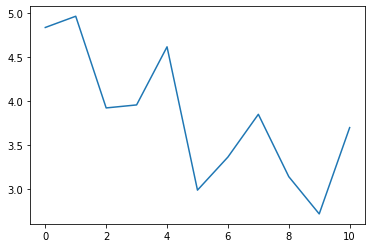

In [8]:
lstlst = [element.cpu().detach().item() for element in eval_reward_lst]
# lstlst = 
print((lstlst))

import seaborn as sns
import matplotlib.pyplot as plt


sns.lineplot(data=lstlst)
plt.show()

In [ ]:
# # !pip install kora
# # from kora import console
# # console.start()
# !pip install procgen
# !wget https://raw.githubusercontent.com/nicklashansen/ppo-procgen-utils/main/utils.py
# !wget https://raw.githubusercontent.com/MishaLaskin/rad/1246bfd6e716669126e12c1f02f393801e1692c1/TransformLayer.py
# # Hyperparameters
# total_steps = 8e6
# num_envs = 32
# num_levels = 100
# num_steps = 256
# num_epochs = 3
# batch_size = 512 #512
# eps = .2
# grad_eps = .5
# value_coef = .5
# entropy_coef = .01

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from utils import make_env, Storage, orthogonal_init
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from utils import make_env, Storage, orthogonal_init
  

# class Flatten(nn.Module):
#     def forward(self, x):
#         return x.view(x.size(0), -1)


# class Encoder(nn.Module):
#   def __init__(self, in_channels, feature_dim):
#     super().__init__()
#     self.layers = nn.Sequential(
#         nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4), nn.ReLU(),
#         nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2), nn.ReLU(),
#         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1), nn.ReLU(),
#         Flatten(),
#         nn.Linear(in_features=1024, out_features=feature_dim), nn.ReLU()
#     )
#     self.apply(orthogonal_init)

#   def forward(self, x):
#     return self.layers(x)


# class Policy(nn.Module):
#   def __init__(self, encoder, feature_dim, num_actions):
#     super().__init__()
#     self.encoder = encoder
#     self.policy = orthogonal_init(nn.Linear(feature_dim, num_actions), gain=.01)
#     self.value = orthogonal_init(nn.Linear(feature_dim, 1), gain=1.)

#   def act(self, x):
#     with torch.no_grad():
#       x = x.cuda().contiguous()
#       dist, value = self.forward(x)
#       action = dist.sample()
#       log_prob = dist.log_prob(action)
    
#     return action.cpu(), log_prob.cpu(), value.cpu()

#   def forward(self, x):
#     x = self.encoder(x)
#     logits = self.policy(x)
#     value = self.value(x).squeeze(1)
#     dist = torch.distributions.Categorical(logits=logits)

#     return dist, value


# # Define environmentbossfight
# # check the utils.py file for info on arguments
# eval_env = make_env(num_envs, env_name = 'starpilot',start_level=num_levels, num_levels=num_levels, use_backgrounds=True)
# obs = eval_env.reset()
# total_reward = []

# # Define network
# encoder = Encoder(3,512)
# policy = Policy(encoder, 512, 15)
# policy.cuda()
# policy.load_state_dict(torch.load('checkpoint.pt'))
# policy.eval()



# frames = []
# total_reward = []

# # Evaluate policy
# policy.eval()#512
# for _ in range(512):

#   # Use policy
#   action, log_prob, value = policy.act(obs)

#   # Take step in environment
#   obs, reward, done, info = eval_env.step(action)
#   total_reward.append(torch.Tensor(reward))

#   # Render environment and store
#   frame = (torch.Tensor(eval_env.render(mode='rgb_array'))*255.).byte()
#   frames.append(frame)

# # Calculate average return
# # total_reward = torch.stack(total_reward).sum(0).mean(0)
# # print('Average return:', total_reward)


In [ ]:
# print(len(total_reward))
# print(len(total_reward[0]))
# ree=0.0
# reet=[]
# for i in range(len(total_reward)):
#     ree+=total_reward[i].mean()
#     reet.append(total_reward[i].mean())
# print(ree)
# print(reet)

In [ ]:
# import imageio

# # Make evaluation environment
# eval_env = make_env(num_envs, env_name = 'bigfish',start_level=num_levels, num_levels=num_levels, use_backgrounds=True)
# obs = eval_env.reset()

# frames = []
# eval_reward_lst=[]
# reward_info_lst=[]
# reward_lst=[]
# for i in range(10):
#   # total_reward = []
#   info_lst=[]
#   reward_lst=[]
  
#   in_channels=eval_env.observation_space.shape[0]
#   encoder =  ImpalaModel(in_channels=in_channels)
#   policy = Policy(encoder, 256, 15)
#   policy.eval()
  
#   # encoder = Encoder(3,512)
#   # policy = Policy(encoder, 512, 15)
#   # policy.eval()
#   if i==9:
#     policy.load_state_dict(torch.load("checknoaugFinalbig.pt"))
#   else:
#     policy.load_state_dict(torch.load(f"checknoaugbig{i}.pt"))

#   policy.cuda()
#   reward_info_lst=[]
#   total_reward=[]
#   for _ in range(256):
    
#     # Use policy
#     action, log_prob, value = policy.act(obs)

#     # Take step in environment
#     obs, reward, done, inf = eval_env.step(action)
    
#     # reward_info_lst.append(info['reward'])
#     # info_lst.append(info)
#     total_reward.append(torch.Tensor(reward))
  
#   # Calculate average return
#   total_reward = torch.stack(total_reward).sum(0).mean(0)
#   eval_reward_lst.append(total_reward)
#   # info_lst=sum(info_lst)/len(info_lst)
